In [1]:
import glob
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_data(experiment):
    rows = []
    # Look through each delay = N ms directory
    for output_dir in glob.glob(f"outputs/{experiment}/*/"):
        delay = int(output_dir[:-1].split("/")[-1].split("ms")[0])
        # Look at each file in that directory
        for output_json in glob.glob(f"{output_dir}/*.json.gz"):
            with gzip.open(output_json, "r") as f_in:
                # Load report
                report = json.load(f_in)
                # Save metrics
                row = {
                    "delay": delay,
                    "runtime": report["runtime"],
                    "n_reads": sum([len(r["reads"]) for r in report["file_reports"]]),
                    "trial": int(output_json.split("_rep")[-1].split(".json.gz")[0])
                }
                rows.append(row)

    df = pd.DataFrame(rows).sort_values("delay")
    aggs = df[["delay", "runtime", "n_reads"]].groupby("delay").agg(["std", "mean", "min", "max"])
    
    return df, aggs

def runtime_plot(aggs, title="", legend_loc=None):
    fig, axes = plt.subplots(figsize=(12, 8))

    # Min/max range
    axes.errorbar(aggs.index, 0.5*(aggs.runtime["max"]+aggs.runtime["min"]),
                  0.5*(aggs.runtime["max"]-aggs.runtime["min"]),
                  linestyle="", capsize=5, color="grey", label="actual [min, max]");
    # Mean +- std
    axes.errorbar(aggs.index, aggs.runtime["mean"], aggs.runtime["std"],
                  linestyle="", linewidth=3, marker="o", markersize=5, color="k", 
                  label=r"mean(actual) $\pm 1\sigma$");
    # Expected
    axes.plot(aggs.index, 2*aggs.index*aggs.n_reads["mean"]/1000.+aggs.runtime["mean"][0], "--", 
              label=r"$%0.3f + N_{reads}\times(2\times delay)/1000$" % aggs.runtime["mean"][0]);

    axes.legend(fontsize=12, loc=legend_loc);
    axes.set_title(title+" ({} reads)".format(aggs.n_reads["mean"][0]), size=16);
    axes.set_xlabel("delay [ms]", size=14);
    axes.set_ylabel("runtime [s]", size=14);
    return fig, axes

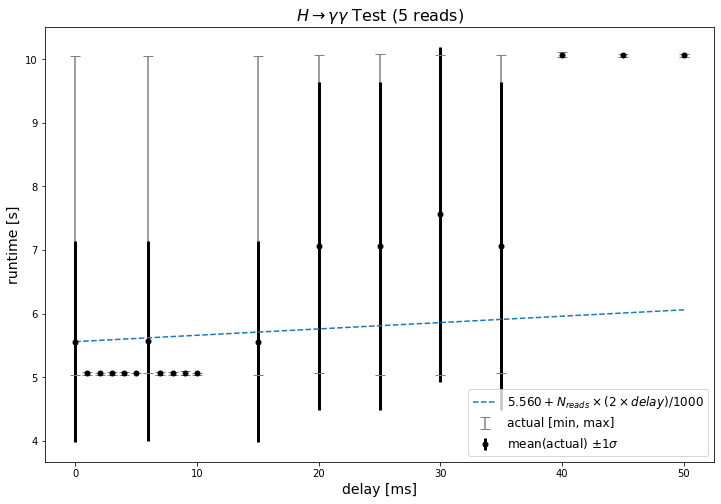

In [3]:
hgg_df, hgg_aggs = get_data("hgg_test")
runtime_plot(hgg_aggs, title=r"$H\rightarrow\gamma\gamma$ Test", legend_loc="lower right");

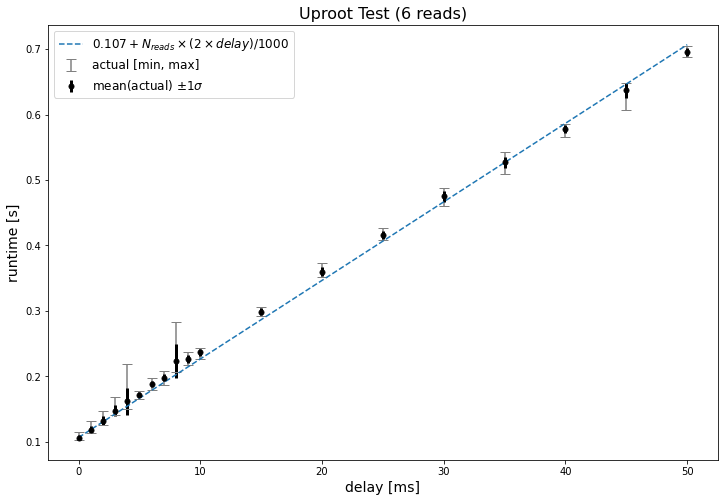

In [4]:
root_df, root_aggs = get_data("root_test")
runtime_plot(root_aggs, title="Uproot Test");

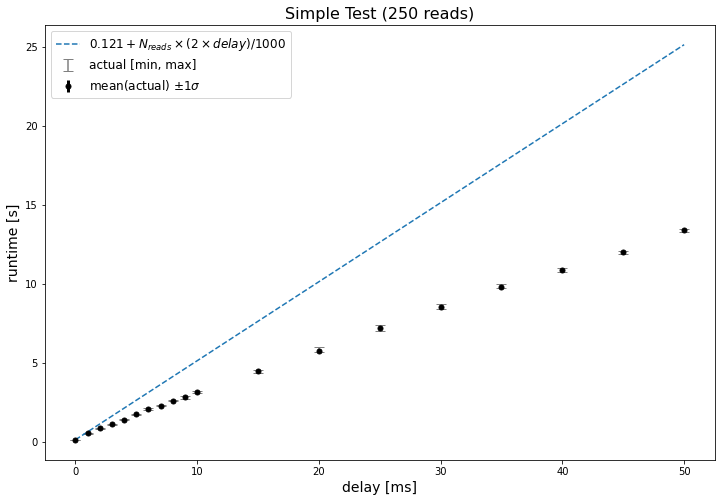

In [5]:
simple_df, simple_aggs = get_data("simple_test")
runtime_plot(simple_aggs, title="Simple Test");